In [ ]:
%load_ext autoreload
%autoreload 2

import datajoint as dj
dj.config["enable_python_native_blobs"] = True
dj.config["database.host"] = '134.2.168.16'
dj.config['schema_name'] = "nnfabrik_monkey_mei"
schema = dj.schema("nnfabrik_monkey_mei")

import os
from os import listdir
from os.path import isfile, join

import torch
import numpy as np
import pickle 
import time
import matplotlib.pyplot as plt
import seaborn as sns

import nnfabrik
from nnfabrik import main, builder
from nnfabrik.main import *

import nnvision
from nnvision.tables.from_nnfabrik import TrainedModel
from nnvision.tables.from_nnfabrik import DataInfo

import insilico_stimuli
from insilico_stimuli.stimuli import *
from insilico_stimuli.parameters import *

In [2]:
# nnfabrik main
from nnvision.tables.main import MonkeyExperiment
from nnvision.tables.from_mei import TrainedEnsembleModel, MEIMethod
from featurevis.main import MEITemplate
from nnvision.tables.measures import OracleScore

@schema
class MEI_update(MEITemplate):
    trained_model_table = TrainedEnsembleModel
    selector_table = MonkeyExperiment.Units

In [3]:
# parameters
dataset_hash = 'a737408da40cfedd036c2eb1b8a31ff1'
ensemble_hash = 'e7a8d0b961ee37ffda0779bfed95f1cf'

data_key = '3631807112901'                   

In [4]:
# get the model 
model_key = (TrainedModel * TrainedEnsembleModel.Member() & dict(ensemble_hash=ensemble_hash)).fetch("KEY", limit=1, order_by="score DESC")
model = TrainedModel().load_model(model_key, include_dataloader=False)
model.eval()

# model readout coordinates from -1, 1 
model_readout_pos = model.readout[data_key].grid  # needs to be converted to canvas size by min-max-normalization

In [5]:
n_units = model.readout[data_key].outdims  # number of model neurons 
total_trials = 30                          # for optimization

unit_idx = 27                              # arbitrary model neuron
unit_id = 28

# image dimensions:
h, w = 41, 41

# 1. Find optimal Gabor

In [6]:
# try different types of input arguments (hybrid example with some "finite" and some "infinite" parameter sets)
canvas_size         = [w, h]
sizes               = UniformRange([10.0, 40.0])
spatial_frequencies = UniformRange([1/40, 1/5])
contrasts           = UniformRange([0.5, 1.0])
orientations        = UniformRange([0.0, np.pi])
phases              = UniformRange([0.0, 2*np.pi])
grey_levels         = FiniteParameter([0.0])
eccentricities      = UniformRange([0.0, 0.9])
locations           = UniformRange([[8.0, 33.0], [8.0, 33.0]])

gabor_set = GaborSet(canvas_size=canvas_size,
                      sizes=sizes,
                      spatial_frequencies=spatial_frequencies,
                      contrasts=contrasts,
                      orientations=orientations,
                      phases=phases, 
                      grey_levels=grey_levels,
                      eccentricities=eccentricities,
                      locations=locations,
                      relative_sf=False)

In [7]:
gabor_set.auto_params

{'location_width': {'name': 'location_width',
  'type': 'range',
  'bounds': [8.0, 33.0],
  'log_scale': False},
 'location_height': {'name': 'location_height',
  'type': 'range',
  'bounds': [8.0, 33.0],
  'log_scale': False},
 'size': {'name': 'size',
  'type': 'range',
  'bounds': [10.0, 40.0],
  'log_scale': False},
 'spatial_frequency': {'name': 'spatial_frequency',
  'type': 'range',
  'bounds': [0.025, 0.2],
  'log_scale': False},
 'contrast': {'name': 'contrast',
  'type': 'range',
  'bounds': [0.5, 1.0],
  'log_scale': False},
 'orientation': {'name': 'orientation',
  'type': 'range',
  'bounds': [0.0, 3.141592653589793],
  'log_scale': False},
 'phase': {'name': 'phase',
  'type': 'range',
  'bounds': [0.0, 6.283185307179586],
  'log_scale': False},
 'gamma': {'name': 'gamma',
  'type': 'range',
  'bounds': [0.18999999999999995, 1.0],
  'log_scale': True},
 'grey_level': {'name': 'grey_level', 'type': 'fixed', 'value': 0.0}}

In [ ]:
# for all model neurons
best_gabor_params_list = []
values_gabor_list = []
for unit in range(0, n_units):
    best_params, values = gabor_set.find_optimal_stimulus(model = model, 
                                                          data_key = data_key,
                                                          unit_idx = unit, 
                                                          total_trials = total_trials)
    best_gabor_params_list.append(best_params)
    values_gabor_list.append(values)

In [17]:
# best parameters dictionary for unit 27
print(best_gabor_params_list[0])

{'location_width': 22.644812609808177, 'location_height': 8.0, 'size': 10.919176836326377, 'spatial_frequency': 0.1951705970661662, 'contrast': 0.5869785840973705, 'orientation': 1.1888746379109845, 'phase': 6.283185307179586, 'gamma': 0.2439036983366026, 'grey_level': 0.0}


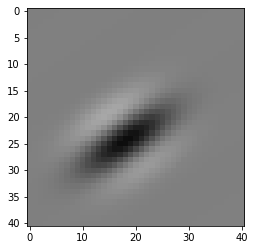

In [15]:
# have a look at the optimal gabor
im_gab_control_unit27 = gabor_set.get_image_from_params(best_gabor_params_list[27])
plt.imshow(im_gab_control_unit27, cmap='gray', vmin=-1, vmax=1)

# 2. Convert the parameters of the optimal Gabor to a circular grating (Control Condition) 

In [16]:
# define a circular grating stimulus (easy example)

size = 10
unit_idx = 27


circular_grating_control_list = []  # init.
 
for unit in range(0, n_units):
    circular_grating_control = CenterSurround(
        canvas_size = [w, h],
        sizes_total = [size],
        sizes_center = [1],                                                                # no surround
        sizes_surround = [1.2],                                                            # some random value higher than 1.0
        contrasts_center = [1.0],                                                          # full contrast (see literature)
        contrasts_surround = [0],                                                          # input doesn't matter
        orientations_center = [best_gabor_params_list[unit]['orientation']],                # orientation from optimal Gabor
        orientations_surround = [0],                                                       # input doesn't matter
        spatial_frequencies_center = [best_gabor_params_list[unit]['spatial_frequency']],  # spatial freq from optimal Gabor
        phases_center = [best_gabor_params_list[unit]['phase']],                           # phase offset from optimal Gabor
        grey_levels = [0.0],
        locations = [[best_gabor_params_list[unit]['location_width'], best_gabor_params_list[unit]['location_height']]])

    circular_grating_control_list.append(circular_grating_control)
    
# have a look at the stimulus we generated for unit 27 
cs_control_unit27 = circular_grating_control_list[unit_idx].stimulus_from_idx(0)
#plt.imshow(cs_control, cmap='gray', vmin=-1, vmax=1)

# Use the model.readout position (3 Experimental Conditions / Paradigms)

We want to evaluate three experimental conditions against the control condition (= find optimal Gabor and use its location). _The first experimental condition_ is to fit a new optimal Gabor, but the locations are set to the model.readout positions, while every other parameter is variable. For _the second experimental condition_, we are using the parameter values from the control condition gabor from orientations and spatial_frequencies. The rest is optimized again separately. We set the locations to the model.readout position and optimize over the size, contrast, eccentricity and phase. For _the third experimental condition_, we are using the parameters for orientation and spatial frequency from the control condition gabor. Then, we adjust the location, which should now be the ones in model.readout. Finally, we are optimizing the circular patch (object type is CenterSurround) over the phase and the size. The resulting stimulus parameters will be our experimental condition 2, which we later compare with the control condition. For the sake of simplicity, we just do this experiment for one unit at a time. 

In [14]:
unit_idx = 27

# how to access the model readout position
loc_norm = model_readout_pos
print(loc_norm[0, unit_idx, 0])  # x and y component of neuron with unit_idx=unit_idx
print(float(loc_norm[0, unit_idx, 0, 1])) # y-component of the readout of neuron with unit_idx=unit_idx 

# coordinates are given normalized from -1 to 1 (needs to be converted to canvas size, max-min-normalization)
loc_w = (w - 0) * (float(loc_norm[0, unit_idx, 0, 0]) - (-1)) / (1 - (-1)) + 0
loc_h = (h - 0) * (float(loc_norm[0, unit_idx, 0, 1]) - (-1)) / (1 - (-1)) + 0

tensor([-0.2687,  0.3289], grad_fn=<SelectBackward>)
0.3289226293563843


In [15]:
# get the model.readout positions for each unit
loc_w = []
loc_h = []

for unit in range(0, n_units):
    # get model.readout position for current unit
    loc_w.append((canvas_size[0] - 0) * (float(loc_norm[0, unit, 0, 0]) - (-1)) / (1 - (-1)) + 0)
    loc_h.append((canvas_size[1] - 0) * (float(loc_norm[0, unit, 0, 1]) - (-1)) / (1 - (-1)) + 0)

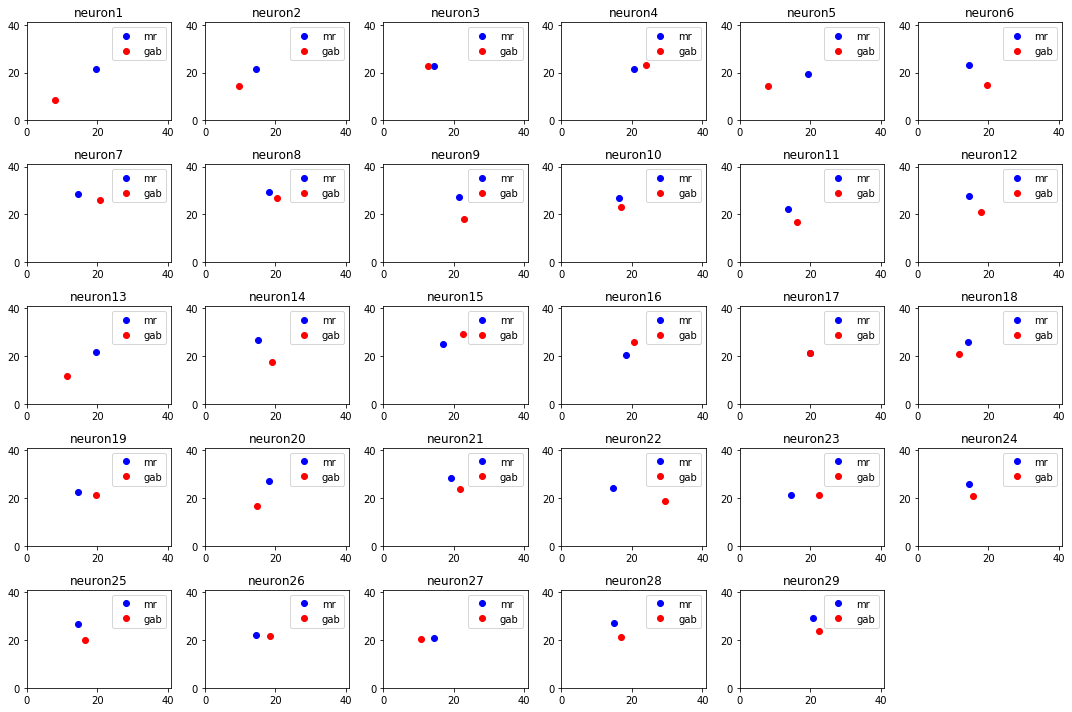

In [16]:
# Compare the model.readout position with the optGab position visually to get a feeling of 
# how different the locations are

rows, cols = 5, 6
fig, ax = plt.subplots(rows, cols, figsize=(15, 10)) # sharex=True, sharey=True

# init.
positions_mr = []
positions_gab = []
unit_idx = 0  # init. counter for plotting loop

# plot the gabor position as a red point and the model.readout position as a blue point for each of the model neurons
for row in range(rows):
    for col in range(cols):
        if unit_idx > 28:
            ax[row, col].axis('off')
        else:
            positions_mr.append([loc_w[unit_idx], loc_h[unit_idx]])
            positions_gab.append([best_gabor_params_list[unit_idx]['location_width'], best_gabor_params_list[unit_idx]['location_height']])
            ax[row, col].plot(positions_mr[unit_idx][0], positions_mr[unit_idx][1], '.', color="b", markersize = 12, label='mr')
            ax[row, col].plot(positions_gab[unit_idx][0], positions_gab[unit_idx][1], '.', color="r", markersize = 12, label='gab')
            ax[row, col].set_title('neuron'+str(unit_idx+1))
            ax[row, col].set_xlim([0, 41])
            ax[row, col].set_ylim([0, 41])
            #ax[row, col].axis('off')
            ax[row, col].legend(loc='best')
            unit_idx += 1
plt.tight_layout()

In [17]:
# Experimental Condition 1: Find completely new Gabor at model.readout position
canvas_size         = [w, h]
sizes               = UniformRange([10.0, 40.0])
spatial_frequencies = UniformRange([1/40, 1/5])
contrasts           = UniformRange([0.5, 1.0])
orientations        = UniformRange([0.0, np.pi])
phases              = UniformRange([0.0, 2*np.pi])
grey_levels         = FiniteParameter([0.0])
eccentricities      = UniformRange([0.0, 0.9])
# locations           = FiniteParameter([[loc_w, loc_h]])

# We need to loop through all units of the model, get their model.readout position, and construct a Gabor with them.

# init
loc_norm = model.readout[data_key].grid
gabor_set_exp1_list = []

for unit in range(0, n_units):
    
    # instantiate the GaborSet based on the unit's model.readout position
    gs = GaborSet(
        canvas_size = canvas_size,
        sizes = sizes,
        spatial_frequencies = spatial_frequencies,
        contrasts = contrasts,
        orientations = orientations,
        phases = phases, 
        grey_levels = grey_levels,
        eccentricities = eccentricities,
        locations = FiniteParameter([[loc_w[unit], loc_h[unit]]]),
        relative_sf = False)
    
    gabor_set_exp1_list.append(gs)

In [ ]:
# find optimal parameters for all units

best_params_exp1_list = []  # init.
values_exp1_list      = []  # init.

for unit in range(0, n_units):
    best_params_exp1, values_exp1 = gabor_set_exp1_list[unit].find_optimal_stimulus(model = model, 
                                                                                    data_key = data_key,
                                                                                    unit_idx = unit, 
                                                                                    total_trials = total_trials)
    best_params_exp1_list.append(best_params_exp1)
    values_exp1_list.append(values_exp1)

The following code fragments are not giving full justice to features of the toolbox. I decided to jot this down like it is because it aids inital understanding. For the better practice, please refer to the Plaids-Contrast.ipynb notebook. 
What do I mean with that?
1.) not looping over the size values when creating the stimuli sets but just inputting them as a FiniteParameter. The resulting parameter combinations will be storedin the class.
2.) Showing the stimuli (with varying size) as batches to the model neuron, NOT separately one at a time.

In [21]:
unit_idx = 27
im_exp1_unit27 = gabor_set_exp1_list[unit_idx].get_image_from_params(best_params_exp1_list[unit_idx])
#plt.imshow(im_exp1_unit27, cmap="gray", vmin=-1, vmax=1)
#plt.title("optimal Gabor - exp. condition 1 - unit:27")

In [22]:
# Experimental Condition 1: defining the corresponding center surround stimulus
size = 10  # some arbitrary size value

circular_grating_exp1_list = []  # init.

for unit in range(0, n_units):
    circular_grating_exp1 = CenterSurround(
        canvas_size=canvas_size,
        sizes_total=[size],
        sizes_center=[1],                                                               # no surround
        sizes_surround=[1.2],                                                           # some random value higher than 1.0
        contrasts_center=[1.0],                                                         # full contrast (see literature)
        contrasts_surround=[0],                                                         # input doesn't matter
        orientations_center=[best_params_exp1_list[unit]['orientation']],               # orientation from optimal Gabor
        orientations_surround=[0],                                                      # input doesn't matter
        spatial_frequencies_center=[best_params_exp1_list[unit]['spatial_frequency']],  # spatial freq from optimal Gabor
        phases_center=[best_params_exp1_list[unit]['phase']],                           # phase offset from optimal Gabor
        grey_levels=[0.0],
        locations=[[best_params_exp1_list[unit]['location_width'], best_params_exp1_list[unit]['location_height']]])
    
    circular_grating_exp1_list.append(circular_grating_exp1)
    
# have a look at the stimulus that we generated for unit 27
cs_exp1_unit27 = circular_grating_exp1_list[unit_idx].stimulus_from_idx(0)

In [23]:
# Experimental Condition 2: Use certain parameters from control condition but now at model.readout position

# before we can generate the circular patch of grating, we need to optimize the Gabor again with 
# respect the new position, namely we need to optimize over the phase again. (here, only for unit 27)

canvas_size         = [w, h]
sizes               = UniformRange([10.0, 40.0])
# spatial_frequencies = FiniteParameter([best_gabor_params_list[unit_idx]['spatial_frequency']])
contrasts           = UniformRange([0.5, 1.0])
# orientations        = FiniteParameter([best_gabor_params_list[unit_idx]['orientation']])
phases              = UniformRange([0.0, 2*np.pi])
grey_levels         = FiniteParameter([0.0])
eccentricities      = UniformRange([0.0, 0.9])
# locations           = FiniteParameter([[loc_w[unit_idx], loc_h[unit_idx]]])  # adjusted model_readout positions


gabor_set_exp2_list = []  # init.

for unit in range(0, n_units):
    gabor_set_exp2 = GaborSet(
        canvas_size = canvas_size,
        sizes = sizes,
        spatial_frequencies = FiniteParameter([best_gabor_params_list[unit]['spatial_frequency']]),
        contrasts = contrasts,
        orientations = FiniteParameter([best_gabor_params_list[unit]['orientation']]),
        phases = phases, 
        grey_levels = grey_levels,
        eccentricities = eccentricities,
        locations = FiniteParameter([[loc_w[unit], loc_h[unit]]]),
        relative_sf = False)
    gabor_set_exp2_list.append(gabor_set_exp2)
    

In [ ]:
# For each unit, find the optimal stimulus

best_params_exp2_list = []  # init.
values_exp2_list      = []  # init.

for unit in range(0, n_units):
    best_params_exp2, values_exp2 = gabor_set_exp2_list[unit].find_optimal_stimulus(model = model, 
                                                                                    data_key = data_key,
                                                                                    unit_idx = unit, 
                                                                                    total_trials = total_trials)
    best_params_exp2_list.append(best_params_exp2)
    values_exp2_list.append(values_exp2)

In [25]:
im_exp2_unit27 = gabor_set_exp2_list[unit_idx].get_image_from_params(best_params_exp2_list[unit_idx])
#plt.imshow(im_exp2_unit27, cmap="gray", vmin=-1, vmax=1)
#plt.title("optimal Gabor - exp. condition 2 - unit:27")

In [26]:
# Experimental Condition 2: defining the corresponding center surround stimulus
size = 10
unit_idx = 27

circular_grating_exp2_list = []  # init.

for unit in range(0, n_units):
    circular_grating_exp2 = CenterSurround(
        canvas_size = canvas_size,
        sizes_total = [size],
        sizes_center = [1],                                                               # no surround
        sizes_surround = [1.2],                                                           # some random value higher than 1.0
        contrasts_center = [1.0],                                                         # full contrast (see literature)
        contrasts_surround = [0],                                                         # input doesn't matter
        orientations_center = [best_params_exp2_list[unit]['orientation']],               # orientation from optimal Gabor
        orientations_surround = [0],                                                      # input doesn't matter
        spatial_frequencies_center = [best_params_exp2_list[unit]['spatial_frequency']],  # spatial freq from optimal Gabor
        phases_center = [best_params_exp2_list[unit]['phase']],                           # phase offset from optimal Gabor
        grey_levels = [0.0],
        locations = [[best_params_exp2_list[unit]['location_width'], best_params_exp2_list[unit]['location_height']]])
    
    circular_grating_exp2_list.append(circular_grating_exp2)

# have a look at the stimulus that we generated for unit 27
cs_exp2_unit27 = circular_grating_exp2_list[unit_idx].stimulus_from_idx(0)

In [27]:
# Experimental Condition 3: 
canvas_size                = [w, h]
sizes_total                = UniformRange([5.0, 15.0])                                                 # size variable
sizes_center               = FiniteParameter([1.0])                                                    # no surround
sizes_surround             = FiniteParameter([1.2])                                                    # some random value higher than 1.0
contrasts_center           = FiniteParameter([1.0])                                                    # full contrast (see literature)
contrasts_surround         = FiniteParameter([0.0])                                                    # input doesn't matter
# orientations_center        = FiniteParameter([best_gabor_params_list[unit_idx]['orientation']])        # orientation from optimal Gabor
orientations_surround      = FiniteParameter([0.0])                                                    # input doesn't matter
# spatial_frequencies_center = FiniteParameter([best_gabor_params_list[unit_idx]['spatial_frequency']])  # spatial freq from optimal Gabor
phases_center              = UniformRange([0.0, 2*np.pi])                                              # phase offset variable
grey_levels                = FiniteParameter([0.0])
locations                  = FiniteParameter([[loc_w, loc_h]])                                         # model.readout position


circular_grating_exp3_list = []  # init.

for unit in range(0, n_units):
    circular_grating_exp3 = CenterSurround(
        canvas_size = canvas_size,
        sizes_total = sizes_total,
        sizes_center = sizes_center,      
        sizes_surround = sizes_surround, 
        contrasts_center = contrasts_center,  
        contrasts_surround = contrasts_surround,  
        orientations_center = FiniteParameter([best_gabor_params_list[unit]['orientation']]),  
        orientations_surround = orientations_surround,  
        spatial_frequencies_center = FiniteParameter([best_gabor_params_list[unit]['spatial_frequency']]),  
        phases_center = phases_center,  
        grey_levels = grey_levels,
        locations = FiniteParameter([[loc_w[unit], loc_h[unit]]]))
    
    circular_grating_exp3_list.append(circular_grating_exp3)


In [ ]:
# For each unit, find the optimal stimulus

best_params_exp3_list = []  # init.
values_exp3_list      = []  # init.

for unit in range(0, n_units):
    best_params_exp3, values_exp3 = circular_grating_exp3_list[unit].find_optimal_stimulus(model = model, 
                                                                                           data_key = data_key,
                                                                                           unit_idx = unit, 
                                                                                           total_trials = total_trials)
    best_params_exp3_list.append(best_params_exp3)
    values_exp3_list.append(values_exp3)

In [29]:
im_exp3_unit27 = circular_grating_exp3_list[unit_idx].get_image_from_params(best_params_exp3_list[unit_idx])
#plt.imshow(im_exp3_unit27, cmap="gray", vmin=-1, vmax=1)
#plt.title("optimal Gabor - exp. condition 3 - unit:27")

In [30]:
# Experimental Condition 3: defining the corresponding center surround stimulus
size = 10

circular_grating_exp3_s_list = []  # init.

for unit in range(0, n_units):
    circular_grating_exp3_s = CenterSurround(
        canvas_size = canvas_size,
        sizes_total = [size],
        sizes_center = [1],                                                                      # no surround
        sizes_surround = [1.2],                                                                  # some random value higher than 1.0
        contrasts_center = [1.0],                                                                # full contrast (see literature)
        contrasts_surround = [0],                                                                # input doesn't matter
        orientations_center = [best_params_exp3_list[unit]['orientation_center']],               # orientation from optimal Gabor
        orientations_surround = [0],                                                             # input doesn't matter
        spatial_frequencies_center = [best_params_exp3_list[unit]['spatial_frequency_center']],  # spatial freq from optimal Gabor
        phases_center = [best_params_exp3_list[unit]['phase_center']],                           # phase offset from optimal Gabor
        grey_levels = [0.0],
        locations = [[best_params_exp3_list[unit]['location_width'], best_params_exp3_list[unit]['location_height']]])

# have a look at the stimulus that we generated for unit 27
cs_exp3_unit27 = circular_grating_exp3_list[unit_idx].stimulus_from_idx(0)

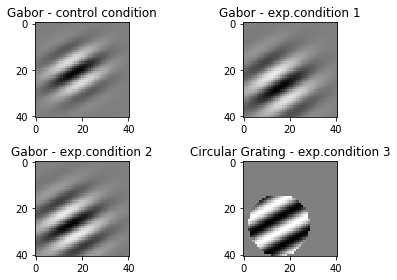

In [31]:
# compare the four optimal stimuli that we generated for unit 27
plt.subplot(221)
plt.imshow(im_gab_control_unit27, cmap='gray', vmin=-1, vmax=1)
plt.title('Gabor - control condition')

plt.subplot(222)
plt.imshow(im_exp1_unit27, cmap='gray', vmin=-1, vmax=1)
plt.title('Gabor - exp.condition 1')

plt.subplot(223)
plt.imshow(im_exp2_unit27, cmap='gray', vmin=-1, vmax=1)
plt.title('Gabor - exp.condition 2')

plt.subplot(224)
plt.imshow(im_exp3_unit27, cmap='gray', vmin=-1, vmax=1)
plt.title('Circular Grating - exp.condition 3')

plt.tight_layout()

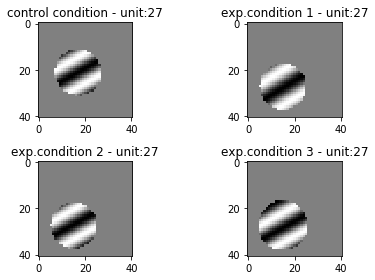

In [32]:
# compare the four circular gratings that we generated for unit 27
plt.subplot(221)
plt.imshow(cs_control_unit27, cmap='gray', vmin=-1, vmax=1)
plt.title('control condition - unit:27')

plt.subplot(222)
plt.imshow(cs_exp1_unit27, cmap='gray', vmin=-1, vmax=1)
plt.title('exp.condition 1 - unit:27')

plt.subplot(223)
plt.imshow(cs_exp2_unit27, cmap='gray', vmin=-1, vmax=1)
plt.title('exp.condition 2 - unit:27')

plt.subplot(224)
plt.imshow(cs_exp3_unit27, cmap='gray', vmin=-1, vmax=1)
plt.title('exp.condition 3 - unit:27')

plt.tight_layout()

# 3. Prepare the stimuli (all units & all sizes) for the Conditions

In [53]:
# define the values for size (for size tuning experiment)
num = 20
size_values = np.linspace(6, 20, num=num)

In [54]:
# define a function which generates Circular Gratings takes a size parameters and returns the center-surround image

# Control Condition: Size Tunings with location based on optimal Gabor
def CS_size_control(size, unit):
    circular_grating = CenterSurround(canvas_size=[w, h],
                                      sizes_total=[size],
                                      sizes_center=[1.0],
                                      sizes_surround=[1.0],
                                      contrasts_center=[1.0],
                                      contrasts_surround=[1],
                                      orientations_center=[best_gabor_params_list[unit]['orientation']],
                                      orientations_surround=[0],
                                      spatial_frequencies_center=[best_gabor_params_list[unit]['spatial_frequency']],
                                      phases_center=[best_gabor_params_list[unit]['phase']],
                                      grey_levels=[0],
                                      locations=[[best_gabor_params_list[unit]['location_width'], best_gabor_params_list[unit]['location_height']]])
    return circular_grating.stimulus_from_idx(0)

# Experimental Condition 1:
def CS_size_exp1(size, unit):
    circular_grating = CenterSurround(canvas_size = [w, h],
                                      sizes_total = [size],
                                      sizes_center = [1.0],
                                      sizes_surround = [1.0],
                                      contrasts_center = [1.0],
                                      contrasts_surround = [1],
                                      orientations_center = [best_params_exp1_list[unit]['orientation']],
                                      orientations_surround = [0],
                                      spatial_frequencies_center = [best_params_exp1_list[unit]['spatial_frequency']],
                                      phases_center = [best_params_exp1_list[unit]['phase']],
                                      grey_levels = [0],
                                      locations = [[best_params_exp1_list[unit]['location_width'], best_params_exp1_list[unit]['location_height']]])
    return circular_grating.stimulus_from_idx(0)

# Experimental Condition 2:
def CS_size_exp2(size, unit):
    circular_grating = CenterSurround(canvas_size=[w, h],
                                      sizes_total=[size],
                                      sizes_center=[1.0],
                                      sizes_surround=[1.0],
                                      contrasts_center=[1.0],
                                      contrasts_surround=[1],
                                      orientations_center=[best_params_exp2_list[unit]['orientation']],
                                      orientations_surround=[0],
                                      spatial_frequencies_center=[best_params_exp2_list[unit]['spatial_frequency']],
                                      phases_center=[best_params_exp2_list[unit]['phase']],
                                      grey_levels=[0],
                                      locations=[[best_params_exp2_list[unit]['location_width'], best_params_exp2_list[unit]['location_height']]])
    return circular_grating.stimulus_from_idx(0)

# Experimental Condition 3:
def CS_size_exp3(size, unit):
    circular_grating = CenterSurround(canvas_size=[w, h],
                                      sizes_total=[size],
                                      sizes_center=[1.0],
                                      sizes_surround=[1.0],
                                      contrasts_center=[1.0],
                                      contrasts_surround=[1],
                                      orientations_center=[best_params_exp3_list[unit]['orientation_center']],
                                      orientations_surround=[0],
                                      spatial_frequencies_center=[best_params_exp3_list[unit]['spatial_frequency_center']],
                                      phases_center=[best_params_exp3_list[unit]['phase_center']],
                                      grey_levels=[0.0],
                                      locations=[[best_params_exp3_list[unit]['location_width'], best_params_exp3_list[unit]['location_height']]])
    return circular_grating.stimulus_from_idx(0)

In [55]:
# 1.) Store the stimuli in the dictionaries images_control, images_exp1, images_exp2, images_exp3.
# The dictionaries will have the keys "unit_XY", indicating the unit index. The size tuning stimuli
# for experimental condition 1 of neuron 0 are thus stored in the list images_exp1['unit_0'].

# init. variables
images_control = {}  # []
images_exp1    = {}  # []
images_exp2    = {}  # []
images_exp3    = {}  # []


# 2.) Store the model activations in a matrix output_XY. The columns represent the units and the columns the 
# different size values.

# init. varibales
output_control = np.zeros((num, n_units))
output_exp1    = np.zeros((num, n_units))
output_exp2    = np.zeros((num, n_units))
output_exp3    = np.zeros((num, n_units))


# for each unit, get the activation for all center-surround stimuli (with 20 different sizes)
for unit in range(0, n_units):
    
    unit_name = "unit_" + str(unit) 
    images_control[unit_name] = []  # init list for unit_XY of control condition
    images_exp1[unit_name] = []  # init list for unit_XY of exp condition 1
    images_exp2[unit_name] = []  # init list for unit_XY of exp condition 2
    images_exp3[unit_name] = []  # init list for unit_XY of exp condition 3
    
    for size_idx, size in enumerate(size_values):        
        # generate the stimuli
        images_control[unit_name].append(CS_size_control(size, unit)) 
        images_exp1[unit_name].append(CS_size_exp1(size, unit)) 
        images_exp2[unit_name].append(CS_size_exp2(size, unit))
        images_exp3[unit_name].append(CS_size_exp3(size, unit))
        
        # control condition - get model activations
        image_control = images_control[unit_name][size_idx].reshape((1, 1, ) + tuple([h, w]))
        image_control = torch.tensor(image_control).expand(1, 1, h, w).float()
        output_control[size_idx, unit] = model(image_control, data_key=data_key).detach().numpy().squeeze()[unit]
        
        # experimental condition 1 - get model activations
        image_exp1 = images_exp1[unit_name][size_idx].reshape((1, 1, ) + tuple([h, w]))
        image_exp1 = torch.tensor(image_exp1).expand(1, 1, h, w).float()
        output_exp1[size_idx, unit] = model(image_exp1, data_key=data_key).detach().numpy().squeeze()[unit]

        # experimental condition 2 - get model activations
        image_exp2 = images_exp2[unit_name][size_idx].reshape((1, 1, ) + tuple([h, w]))
        image_exp2 = torch.tensor(image_exp2).expand(1, 1, h, w).float()
        output_exp2[size_idx, unit] = model(image_exp2, data_key=data_key).detach().numpy().squeeze()[unit]
        
        # experimental condition 3 - get model activations
        image_exp3 = images_exp3[unit_name][size_idx].reshape((1, 1, ) + tuple([h, w]))
        image_exp3 = torch.tensor(image_exp3).expand(1, 1, h, w).float()
        output_exp3[size_idx, unit] = model(image_exp3, data_key=data_key).detach().numpy().squeeze()[unit]


In [56]:
# activations for unit 0 
print(output_exp1[:, 0])

[0.9414224  0.86704469 0.82953417 0.80521578 0.79128075 0.78217018
 0.76794624 0.78131914 0.80190969 0.81319398 0.81159258 0.80610794
 0.79960448 0.79917407 0.81281918 0.82648534 0.83287179 0.82917684
 0.81570333 0.80697185]


# 3. Plot the circular grating stimuli that we input to the model

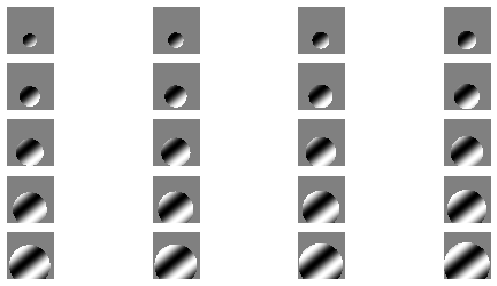

In [73]:
# show the corresponding stimuli for desired unit
unit_name = 'unit_20'

plt.figure(figsize=(10, 5))

for i, img in enumerate(images_exp[unit_name]):
    plt.subplot(5, 4, i + 1)
    plt.imshow(img, cmap='gray', vmin=-1, vmax=1)
    plt.axis('off')

# 4. Plot the size tunings

Before we plot the size tuning curves, we make some crucial normalizations. These will aid comparison between units and size values. We are normalizing the activations for each model neuron with the highest activation. We are also converting the x-axis to _visual angle_. In the model we are using here, 35 pixels equates to 1 visual degree.

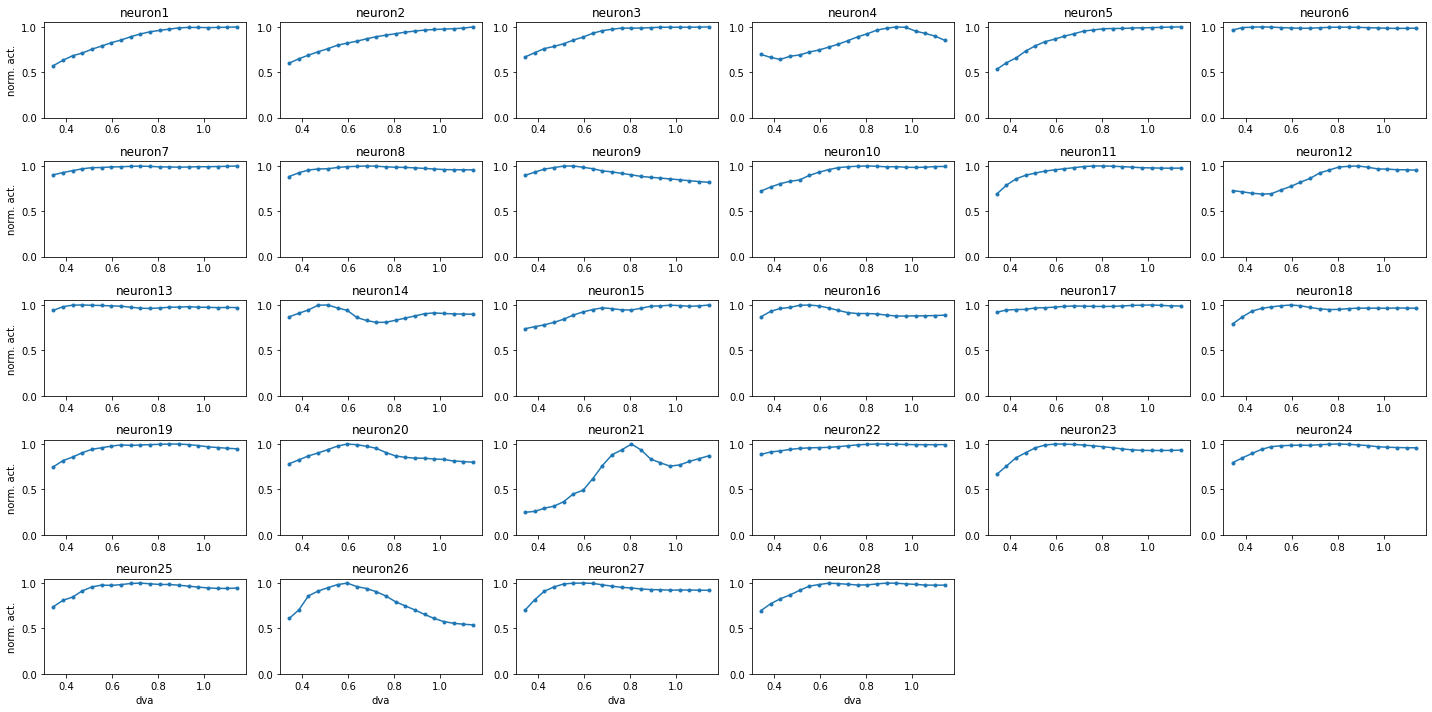

In [58]:
# Control Condition

# convert the sizes from #pixels to visual degrees
cf = 2/(35)  # conversion factor from #pixels to visual degree (pixel size of stimulus is given by diameter of circle)
visual_degree = size_values * cf

# prepare figure
rows, cols = 5, 6
fig, ax = plt.subplots(rows, cols, figsize=(20, 10)) # sharex=True, sharey=True

unit_idx=0
for row in range(rows):
    for col in range(cols):
        unit_idx += 1
        if unit_idx > n_units-1:
            #ax[row, col].get_xaxis().set_visible(False)
            #ax[row, col].get_yaxis().set_visible(False)
            ax[row, col].axis('off')
        else:
            max_act = np.max(output_control[:, unit_idx])  # normalized activations
            ax[row, col].plot(visual_degree, output_control[:, unit_idx] / max_act, '.-')
            ax[row, col].set_title('neuron'+str(unit_idx))
            ax[row, col].set_ylim([0.0, 1.05])
            if col == 0:
                ax[row, col].set_ylabel('norm. act.')
            if row == rows-1: 
                ax[row, col].set_xlabel('dva')
fig.tight_layout()

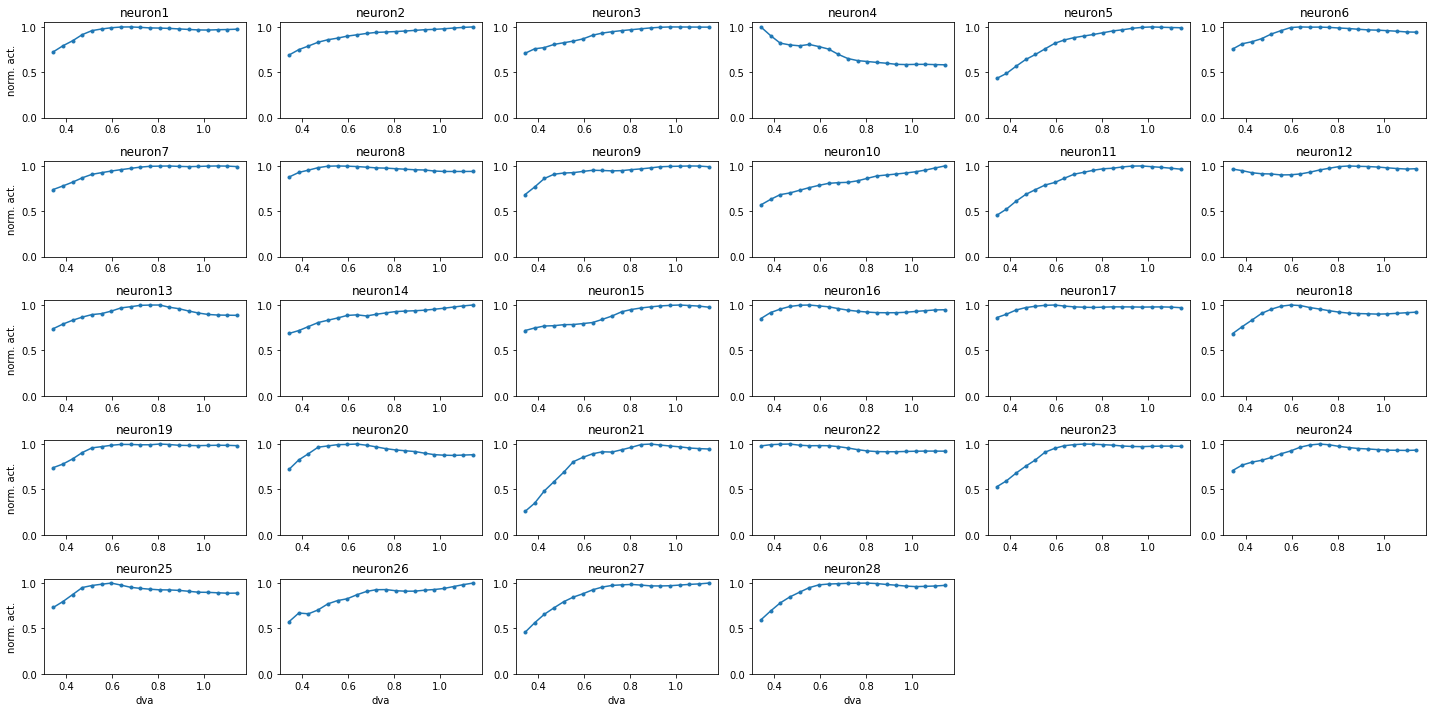

In [59]:
# Experimental Condition 1

# prepare figure
rows, cols = 5, 6
fig, ax = plt.subplots(rows, cols, figsize=(20, 10)) # sharex=True, sharey=True

unit_idx=0
for row in range(rows):
    for col in range(cols):
        unit_idx += 1
        if unit_idx > n_units-1:
            #ax[row, col].get_xaxis().set_visible(False)
            #ax[row, col].get_yaxis().set_visible(False)
            ax[row, col].axis('off')
        else:
            max_act = np.max(output_exp1[:, unit_idx])  # normalized activations
            ax[row, col].plot(visual_degree, output_exp1[:, unit_idx] / max_act, '.-')
            ax[row, col].set_title('neuron'+str(unit_idx))
            ax[row, col].set_ylim([0.0, 1.05])
            if col == 0:
                ax[row, col].set_ylabel('norm. act.')
            if row == rows-1: 
                ax[row, col].set_xlabel('dva')
fig.tight_layout()

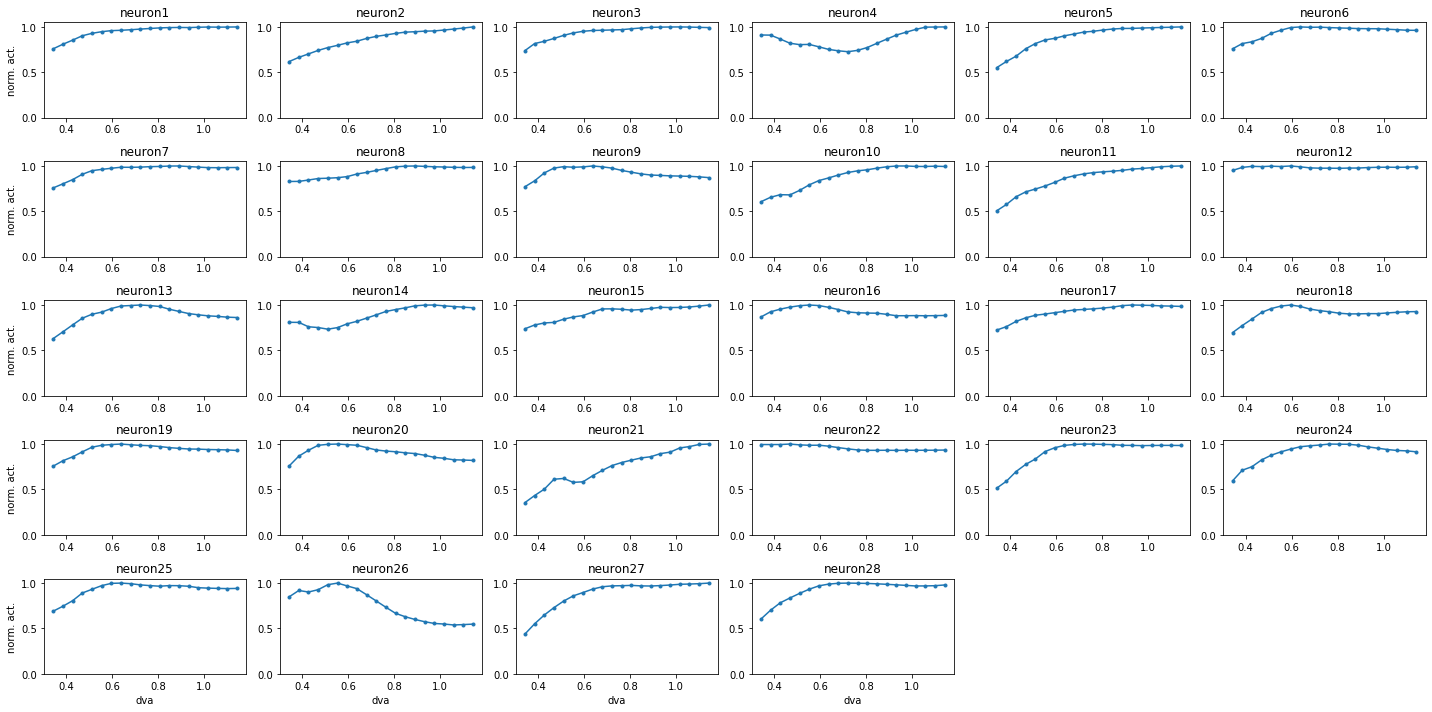

In [60]:
# Experimental Condition 2

# prepare figure
rows, cols = 5, 6
fig, ax = plt.subplots(rows, cols, figsize=(20, 10)) # sharex=True, sharey=True

unit_idx=0
for row in range(rows):
    for col in range(cols):
        unit_idx += 1
        if unit_idx > n_units-1:
            #ax[row, col].get_xaxis().set_visible(False)
            #ax[row, col].get_yaxis().set_visible(False)
            ax[row, col].axis('off')
        else:
            max_act = np.max(output_exp2[:, unit_idx])  # normalized activations
            ax[row, col].plot(visual_degree, output_exp2[:, unit_idx] / max_act, '.-')
            ax[row, col].set_title('neuron'+str(unit_idx))
            ax[row, col].set_ylim([0.0, 1.05])
            if col == 0:
                ax[row, col].set_ylabel('norm. act.')
            if row == rows-1: 
                ax[row, col].set_xlabel('dva')
fig.tight_layout()

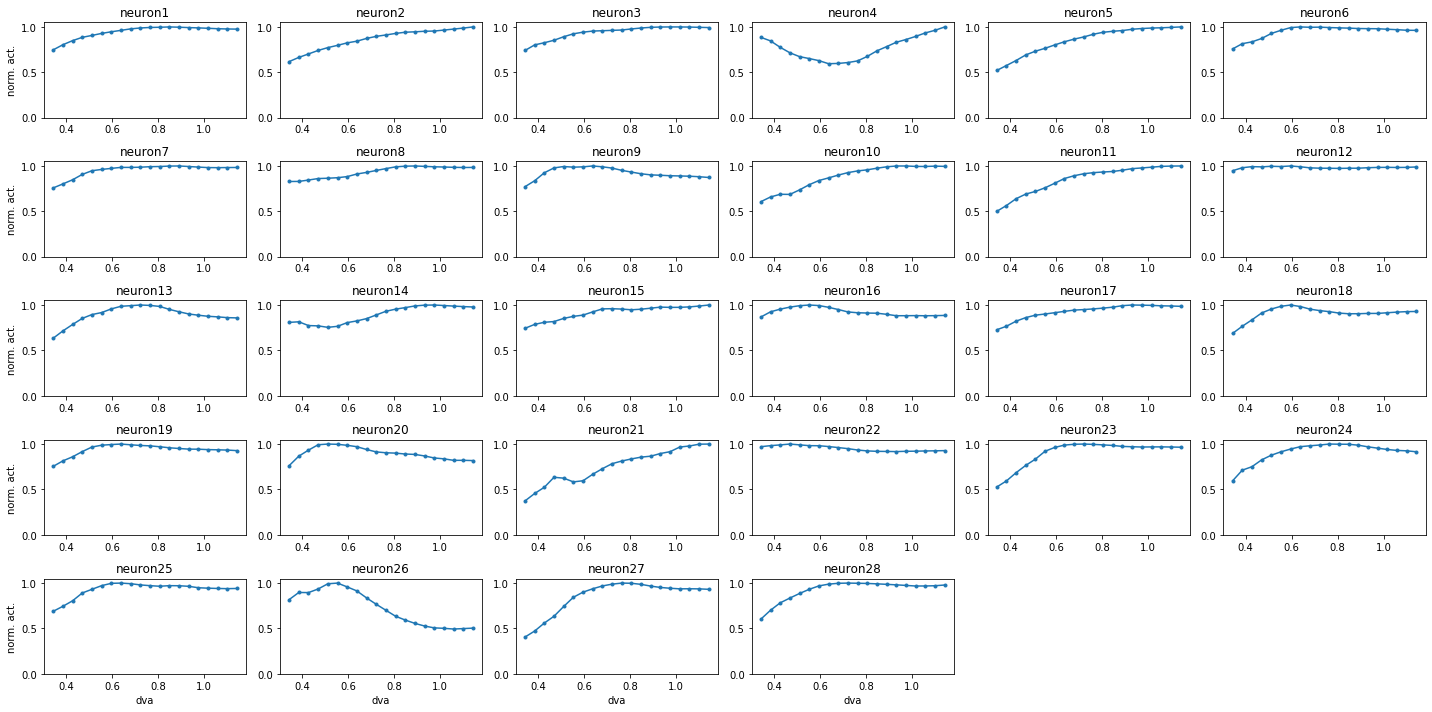

In [61]:
# Experimental Condition 3

# prepare figure
rows, cols = 5, 6
fig, ax = plt.subplots(rows, cols, figsize=(20, 10)) # sharex=True, sharey=True

unit_idx=0
for row in range(rows):
    for col in range(cols):
        unit_idx += 1
        if unit_idx > n_units-1:
            #ax[row, col].get_xaxis().set_visible(False)
            #ax[row, col].get_yaxis().set_visible(False)
            ax[row, col].axis('off')
        else:
            max_act = np.max(output_exp3[:, unit_idx])  # normalized activations
            ax[row, col].plot(visual_degree, output_exp3[:, unit_idx] / max_act, '.-')
            ax[row, col].set_title('neuron'+str(unit_idx))
            ax[row, col].set_ylim([0.0, 1.05])
            if col == 0:
                ax[row, col].set_ylabel('norm. act.')
            if row == rows-1: 
                ax[row, col].set_xlabel('dva')
fig.tight_layout()

# 5. Gabor size tuning: Get the model activations for the different Gabor stimuli 

First of all, this is not a classical experiment. So we are not expecting anything from the experiment. It is just a toy example.

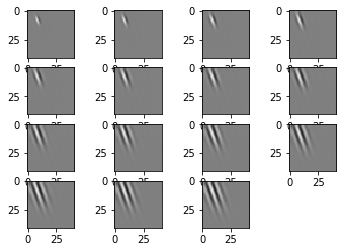

In [75]:
num = 15
n_units = model.readout[data_key].outdims
size_values = np.linspace(10.0, 40.0, num=num)
activations = np.zeros((num, n_units))

for unit_idx, param_comb in enumerate(best_gabor_params_list):
    for size_idx, size in enumerate(size_values):  # Fix the optimal Gabor parameters and vary the size parameter
        param_comb['size'] = size
        dic = param_comb.copy()  # important, otherwise train_evaluate changes the dictionary
        if unit_idx == 0:
            plt.subplot(4, 4, size_idx + 1)
            plt.imshow(gabor_set.get_image_from_params(dic), cmap='gray', vmin=-1, vmax=1)
        
        activations[size_idx, unit_idx] = gabor_set.train_evaluate(auto_params=param_comb.copy(),
                                                                   model=model, 
                                                                   data_key=data_key,
                                                                   unit_idx=unit_idx)

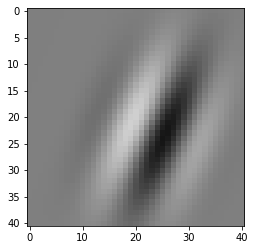

In [76]:
im = gabor_set.get_image_from_params(param_comb.copy())
plt.imshow(im, cmap="gray", vmin=-1, vmax=1)

In [108]:
# activations for neuron 1
activations[:,0]

array([1.48692763, 1.48503101, 1.48215258, 1.47867548, 1.47525311,
       1.47262609, 1.47137284, 1.46936059, 1.4675566 , 1.46585166,
       1.46394598, 1.46157312, 1.45843899, 1.45432127, 1.44916654])

# 6. Gabor size tuning: Create the tuning curve

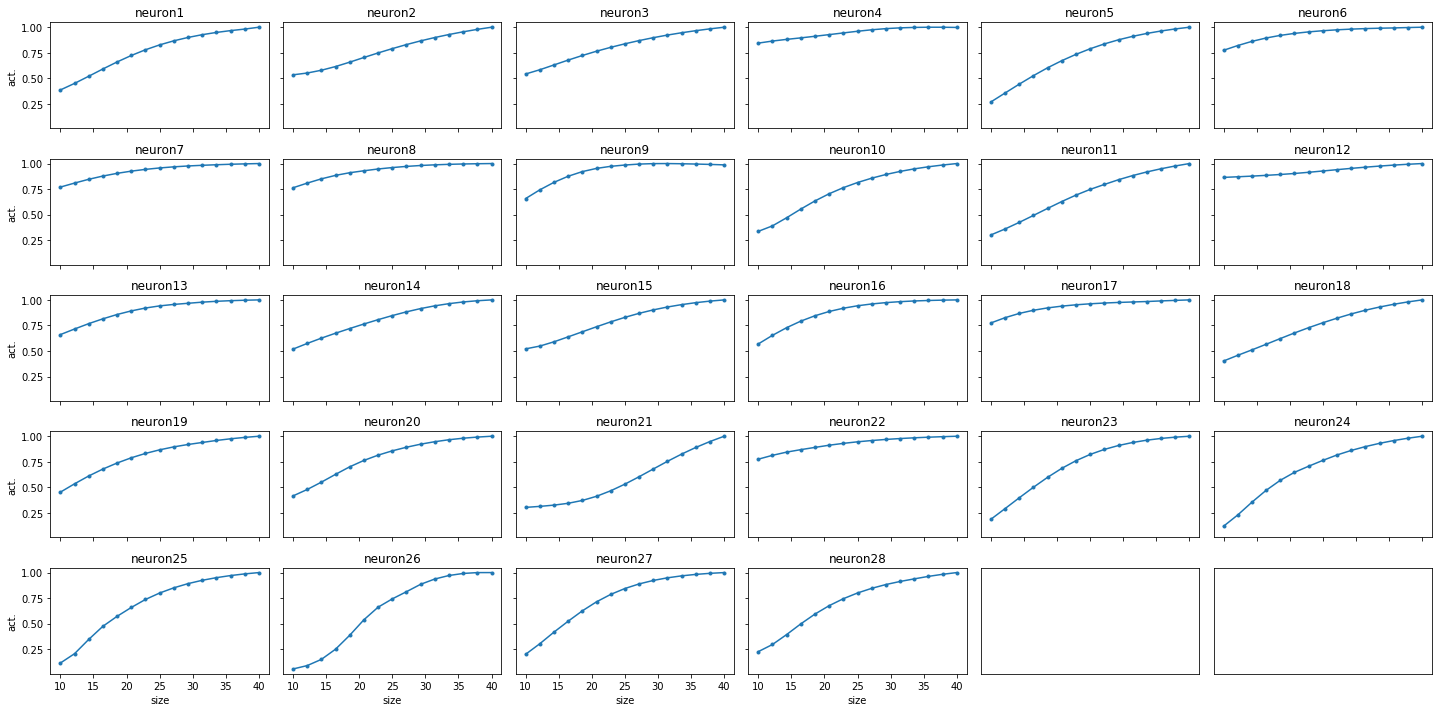

In [110]:
rows, cols = 5, 6
fig, ax = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(20, 10))

unit_idx=0
for row in range(rows):
    for col in range(cols):
        unit_idx += 1
        if unit_idx > n_units-1:
            ax[row, col].get_xaxis().set_visible(False)
            ax[row, col].get_yaxis().set_visible(False)
        else:
            max_act = np.max(activations[:, unit_idx])
            ax[row, col].plot(size_values, activations[:, unit_idx] / max_act, '.-')
            ax[row, col].set_title('neuron'+str(unit_idx))
            if col == 0:
                ax[row, col].set_ylabel('act.')
            if row == rows-1: 
                ax[row, col].set_xlabel('size')
        #ax[row, col].get_xaxis().set_visible(False)
        #ax[row, col].get_yaxis().set_visible(False)
fig.tight_layout()